# Filtering a noisy speech signal

**Topics**
* Intro to wiener filters

**Learning goals**
* Familiarity with calculating filter properties based on signal analysis
* Designing a filter with arbitrary frequency response using the frequency sampling method

**Libraries and notebook config:**


In [ ]:
from scipy.io import wavfile
import scipy.signal as sig
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

%matplotlib inline

## A brief intro to Wiener Filtering of speech signals

By now you should be familiar with the frequency domain properties of FIR filters, and how designing a FIR filter can be fairly straightforward once you know the deisired shape of the frequency response. But what if there is no simple lowpass or highpass filter you can design beforehand which will do the trick? In this problem we will have a look at a method for designing a filter for suppressing noise in a speech signal which may be automated (although we will do it manually here).

First, let's get some definitions out of the way. A speech signal $s[n]$ is recorded alongside noise $v[n]$ (in this example we simply use white noise, but a possible practical usecase may be wind causing disturbances in the microphone). The samples produced by the microphone are $x[n] = s[n] + v[n]$, and our goal is to calculate a filter $h[n]$ which when applied to $x[n]$ will maximize the Signal-to-Noise Ratio of the output, where the output Signal-to-Noise ratio can be described as:

$$\text{SNR} = \frac{E(|h[n]*s[n]|^2)}{E(|h[n]*v[n]|^2)}$$

This ideal filter is known as a [wiener filter](https://en.wikipedia.org/wiki/Wiener_filter) and may, assuming there is no correlation between $s[n]$ and $v[n]$ (i.e. $E(s[n]\cdot v[n-l]) = 0$), be expressed as

$$H_{\text{opt}}(\hat{\omega}) = \frac{S_{ss}(\hat{\omega})}{S_{xx}(\hat{\omega})}$$

where $S_{ss}(\hat{\omega})$ is the power spectral density (PSD) of the speech signal $s[n]$, and $S_{xx}(\hat{\omega})$ is the PSD of the sampled signal $x[n]$. OK, so far so good, but this leaves us with a new problem: that of estimating what the PSD of a speech signal $s[n]$ which is buried in noise. Here is where we can employ one of signal processing's neat little tricks: *it is often far easier acquire information on interfering noise rather than a desired signal, and if you can design a filter to maximise Noise-to-Signal Ratio, it's complementary filter should maximize Signal-to-Noise Ratio.*

In a speech signal for instance, we can assume that there will be intermittent pauses between words/sentences where $s[n] \approx 0$ and $x[n] \approx v[n]$. The code cell below loads the content of an audio file `speech_w_noise.wav` into an array `xn`, and both plots the audio envelope as well as loading an audio playback of the signal.

fs =22050
[-0.07345805 -0.07574694 -0.06247139 ... -0.06524857  0.1424604
 -0.10333567]


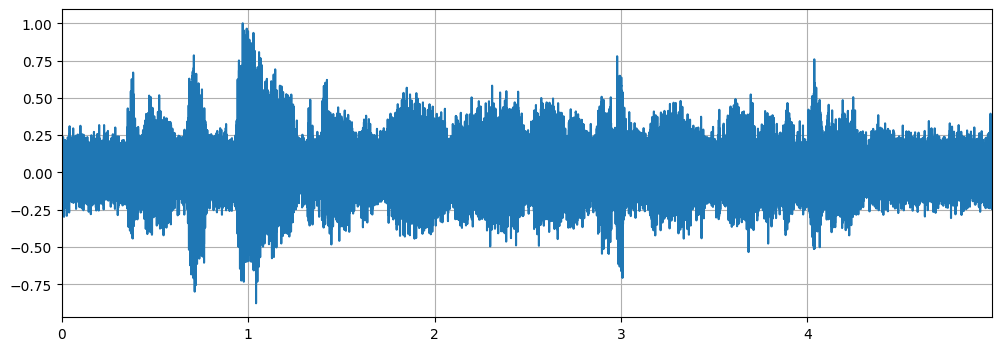

In [7]:
fs, data = wavfile.read("speech_w_noise.wav")
xn = data/max(abs(data))

plt.close(1); plt.figure(1, figsize=(12,4))
plt.plot(np.linspace(0, len(xn)/fs, len(xn), endpoint=False), xn)
plt.grid(True)
plt.xlim([0, len(xn)/fs])

Audio(xn, rate=fs)
print(f"{fs =}")
print(xn)

## a)

Study the audio envelope in the above figure. Use slicing to select one signal segment containing only noise, and one signal segment dominated by speech (the longer the better). If in doubt, try listening to the segments to see if they have the desired content.

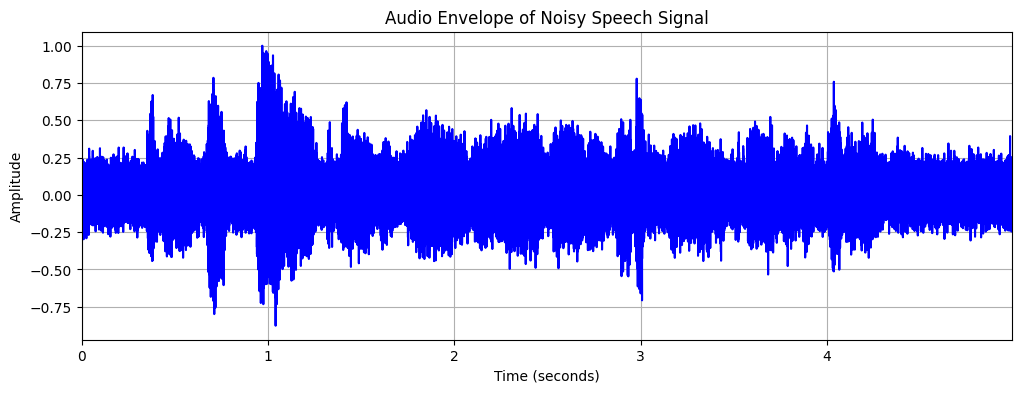

Playing entire noisy signal:


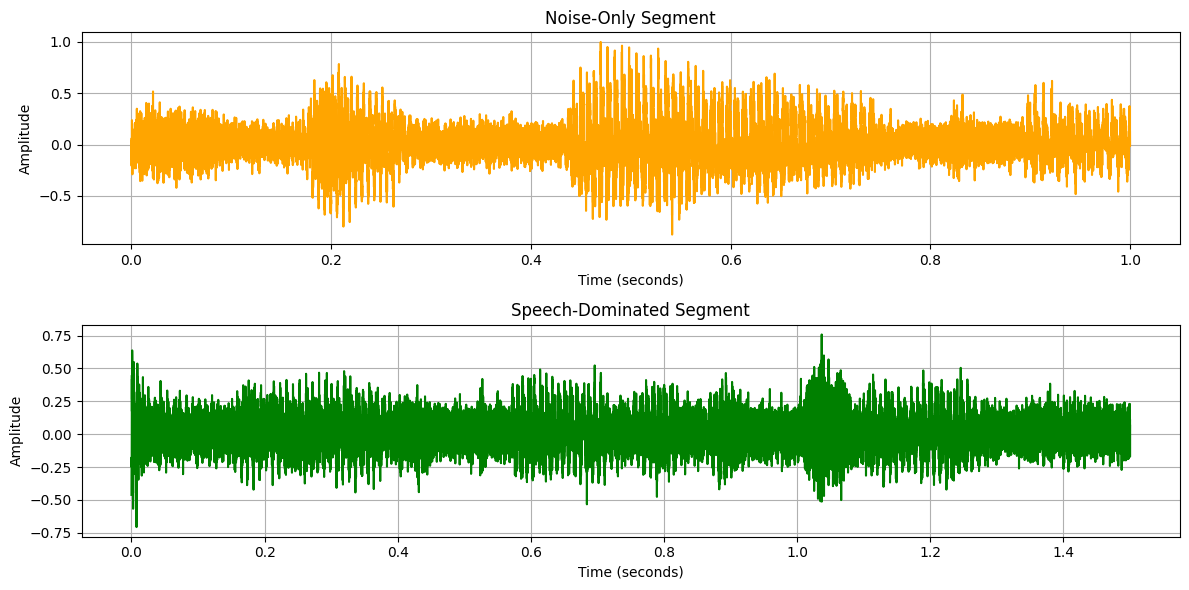

Playing speech-dominated segment:


In [9]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

# Load and normalize the noisy speech signal
fs, data = wavfile.read("speech_w_noise.wav")
xn = data / max(abs(data))  # Normalize signal to range [-1, 1]

# Plot the audio envelope
time_axis = np.linspace(0, len(xn) / fs, len(xn), endpoint=False)
plt.figure(figsize=(12, 4))
plt.plot(time_axis, xn, color='blue')
plt.title("Audio Envelope of Noisy Speech Signal")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.xlim([0, len(xn) / fs])
plt.show()

# Play the entire noisy signal to understand its pattern
print("Playing entire noisy signal:")
#Audio(xn, rate=fs)

# Slicing segments based on observed quiet and loud sections from the plot
# These values are examples and may need adjustment based on actual observations
noise_start = int(0.5 * fs)  # Start index for noise segment (0.5s mark as example)
noise_end = int(1.5 * fs)    # End index for noise segment (1.5s mark as example)
noise_segment = xn[noise_start:noise_end]

speech_start = int(3.0 * fs)  # Start index for speech segment (3s mark as example)
speech_end = int(4.5 * fs)    # End index for speech segment (4.5s mark as example)
speech_segment = xn[speech_start:speech_end]

# Plot selected segments for verification
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, (noise_end - noise_start) / fs, noise_end - noise_start), noise_segment, color='orange')
plt.title("Noise-Only Segment")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, (speech_end - speech_start) / fs, speech_end - speech_start), speech_segment, color='green')
plt.title("Speech-Dominated Segment")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

# Play the noise and speech segments for verification
#print("Playing noise-only segment:")
#Audio(noise_segment, rate=fs)

print("Playing speech-dominated segment:")
Audio(speech_segment, rate=fs)



## b) 
Choose a number of filter taps which you think sounds promising (e.g. $M=128$), and use function [welch](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html) to estimate the power spectral density `S_xx` and `S_vv` of both segments from part **a)** with resolution $M$ (`nfft=M`). Then, calculate the frequency response $H_v(\hat{\omega})=\frac{S_{vv}(\hat{\omega})}{S_{xx}(\hat{\omega})}$ and show the magnitude response curve in a plot.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import welch

# Load and normalize the noisy speech signal
fs, data = wavfile.read("speech_w_noise.wav")
xn = data / max(abs(data))  # Normalize signal to range [-1, 1]

# Choose segment indices for noise and speech-dominated segments
noise_start = int(0.5 * fs)  # Adjust based on plot from task a
noise_end = int(1.5 * fs)
noise_segment = xn[noise_start:noise_end]

speech_start = int(3.0 * fs)
speech_end = int(4.5 * fs)
speech_segment = xn[speech_start:speech_end]

#number of filter taps
h_len = 128

# Estimate PSD for both segments using Welch's method
# nfft must be greater than or equal to nperseg.
f_xx, S_xx = welch(speech_segment, fs=fs, nperseg=h_len, nfft=h_len)  
f_vv, S_vv = welch(noise_segment, fs=fs, nperseg=h_len, nfft=h_len)  

# Calculate the Wiener filter frequency response H_v(omega) = S_xx / S_vv
H_v = S_xx / S_vv

# Apply gain cap to enhance the filter's magnitude response with upper limit of 1
H_v_capped = np.minimum(H_v, 1)

# Plot the capped magnitude response of H_v
plt.figure(figsize=(10, 5))
plt.plot(f_xx, np.abs(H_v_capped), label=r"$|H_v(\omega)|$ with Gain Cap")
plt.title("Enhanced Magnitude Response of Wiener Filter Frequency Response $H_v(\\omega)$ with Cap")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()
plt.show()



ValueError: nfft must be greater than or equal to nperseg.

[Here](figures/task4b_lf.png) is an example of what the noise enhancing filter's magnitude response might look like. Here, i have set an upper limit for filter gain at $1$.

## c) 
Calculate the frequency response of the complimentary filter  $H_s(\hat{\omega}) = 1 - H_v(\hat{\omega})$. The array of $M$ values representing $H_s(\hat{\omega})$ can soon be transformed back to the time domain to acquire an impulse response $h[n]$, but there is a final adjustment we need to make first: 
>Seeing as our filter is supposed to be causal, it is practically impossible for the filter to have a phase response $\angle H_s(\hat{\omega}) = 0$, but this is basically what our current frequency response attempts to do. To account for this, we must add $D=\frac{M-1}{2}$ samples of delay to ensure symmetry properties of the impulse response $h_s[n]$. This is done by *in the frequency domain* adjusting the angle of the frequency response accordingly:
>
>$$H_s(\hat{\omega}) \cdot e^{-j\hat{\omega}D}$$
>
>PS: Using this method it is perfectly possible to impose a fractional delay (e.g. $63.5$ samples)

Once you have your phase adjusted frequency response, an impulse response with somewhat suitable frequency-domain properties may be found using `irfft`. What we are doing is often referred to as the frequency sampling filter design method, and is explained thoroughly in chapter 7.4. 

Verify your work by creating a figure showing both a high-resolution magnitude response $|H_s(\hat{\omega})|$ of the filter, as well as the impulse response $h[n]$.

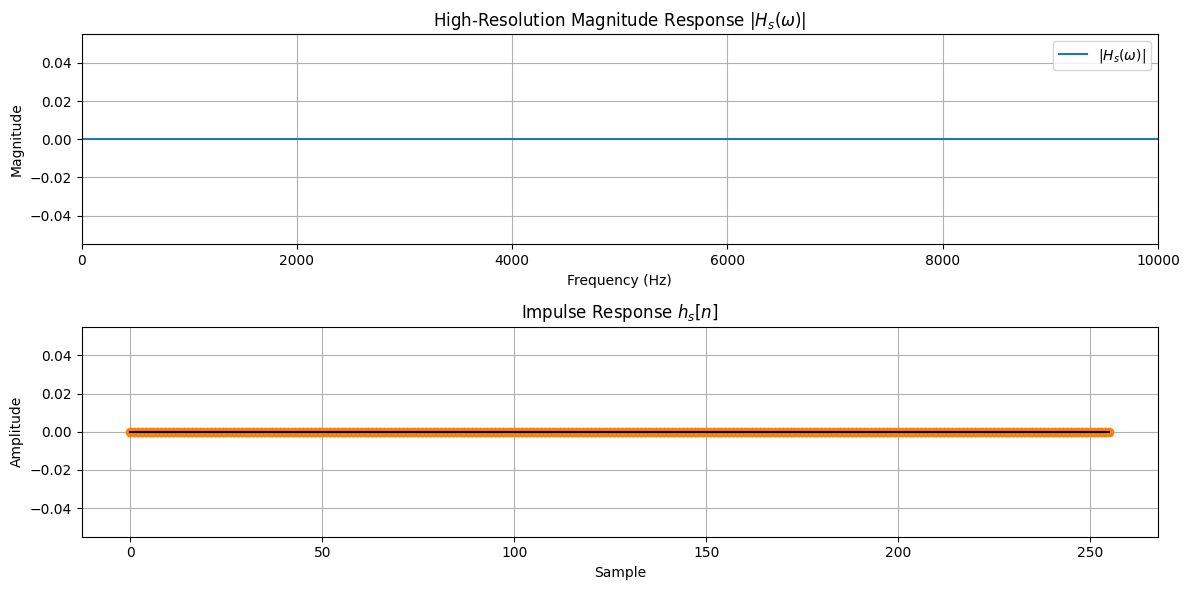

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, csd
from scipy.fft import irfft, rfftfreq

# Load and normalize the noisy speech signal
fs, data = wavfile.read("speech_w_noise.wav")
xn = data / max(abs(data))  # Normalize signal to range [-1, 1]

# Choose segment indices for noise and speech-dominated segments
noise_start = int(0.5 * fs)  # Adjust based on plot from task a
noise_end = int(1.5 * fs)
noise_segment = xn[noise_start:noise_end]

speech_start = int(3.0 * fs)
speech_end = int(4.5 * fs)
speech_segment = xn[speech_start:speech_end]

h_len = 256

#f_xx, S_xx = welch(speech_segment, fs=fs, nperseg=M, nfft=M)  
#f_vv, S_vv = welch(noise_segment, fs=fs, nperseg=M, nfft=M)   

f_filt, P_xx = welch(speech_segment, fs=fs, nperseg=h_len, noverlap=h_len//2)  # Calculate PSD of x[n]
f_filt, P_vv = welch(noise_segment, fs=fs, nperseg=h_len, noverlap=h_len//2)  # Calculate PSD of x[n]

# Calculate Wiener filter frequency response H_v(omega) = S_xx / S_vv

noise_floor = np.median(P_xx)  # Estimate noise level

P_vv = np.where(P_xx < noise_floor*1.5, P_xx, noise_floor)  # Separate noise PSD by setting a threshold for what constitutes a "signal"

H_v = P_xx / P_vv

# Apply gain cap to enhance the filter's magnitude response with upper limit of 1
H_v_capped = np.minimum(H_v, 1)

# Calculate the complementary filter frequency response H_s(omega) = 1 - H_v(omega)
H_s = 1 - H_v_capped
D = (h_len - 1) / 2  
frequencies = rfftfreq(h_len, 1/fs)  
H_s_phase_adjusted = H_s * np.exp(-1j * 2 * np.pi * frequencies * D)


h_s = irfft(H_s_phase_adjusted, n=h_len)

# High-resolution frequency response plot for verification
plt.figure(figsize=(12, 6))

# Plot high-resolution magnitude response of H_s
high_res_freqs = rfftfreq(1024, 1/fs)  # High-resolution frequency axis
plt.subplot(2, 1, 1)
plt.plot(frequencies, np.abs(H_s), label=r"$|H_s(\omega)|$")
plt.xlim([0, 10000])
plt.title("High-Resolution Magnitude Response $|H_s(\\omega)|$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.legend()

# Plot the impulse response h_s[n]
plt.subplot(2, 1, 2)
plt.stem(h_s, linefmt='C1-', markerfmt='C1o', basefmt='k')
plt.title("Impulse Response $h_s[n]$")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()


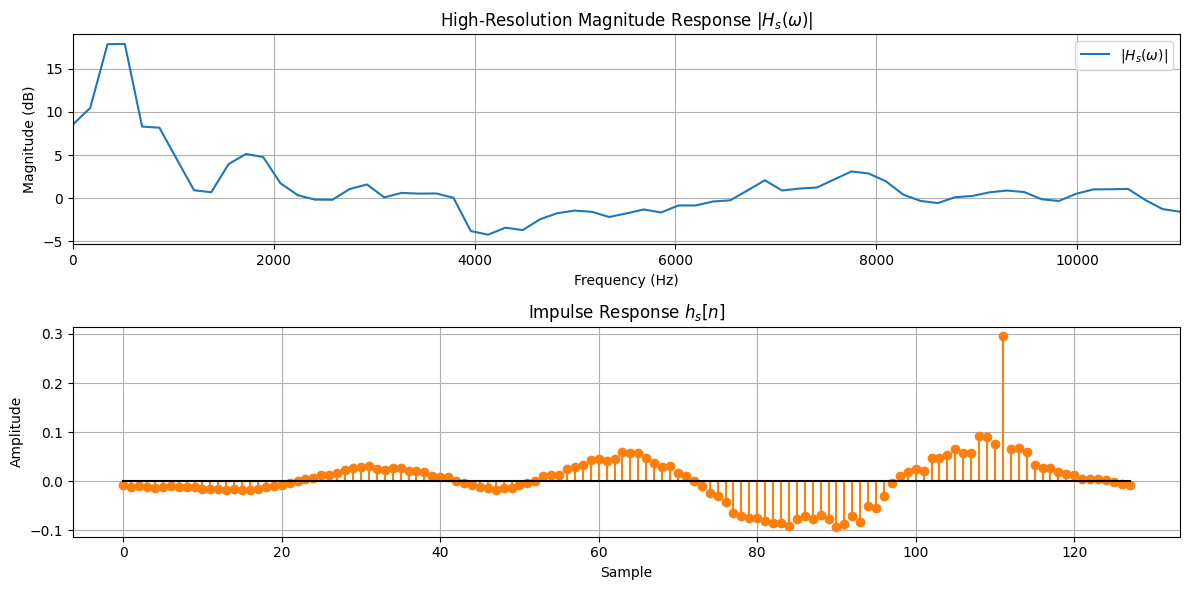

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import welch, windows
from scipy.fft import irfft, rfftfreq

fs, data = wavfile.read("speech_w_noise.wav")
xn = data / max(abs(data))  
h_len = 128

# Split signal into speech + noise (full signal) and noise-only segments
noise_start = int(0.5 * fs)  # Adjust based on plot from task a
noise_end = int(1.5 * fs)
noise_segment = xn[noise_start:noise_end]

speech_start = int(3.0 * fs)
speech_end = int(4.5 * fs)
speech_segment = xn[speech_start:speech_end]

# Estimate PSD of speech+noise and noise segments using Welch's method
f_filt, P_xx = welch(speech_segment, fs=fs, nperseg=h_len, noverlap=h_len//2)  # PSD of speech + noise
_, P_vv = welch(noise_segment, fs=fs, nperseg=h_len, noverlap=h_len//2)  # PSD of noise-only

P_ss = P_xx - P_vv
H_v = P_ss / (P_ss + P_vv)

# Apply gain cap to limit the maximum value of H_v
H_v_capped = np.minimum(H_v, 1)

# Calculate the complementary filter frequency response H_s(omega) = 1 - H_v(omega)
H_s = 1 - H_v_capped

# Apply phase delay to make the filter causal
D = (h_len - 1) / 2  
frequencies = rfftfreq(h_len, 1/fs)  
H_s_phase_adjusted = H_s * np.exp(-1j * 2 * np.pi * frequencies * D)

h_s = irfft(H_s_phase_adjusted, n=h_len)
h_s_windowed = h_s * windows.hamming(h_len)

plt.figure(figsize=(12, 6))

# High-resolution frequency response plot of |H_s(ω)|
plt.subplot(2, 1, 1)
f_high_res, H_s_high_res = welch(speech_segment, fs=fs, nperseg=1024, noverlap=512)
plt.plot(f_filt, 20 * np.log10(np.abs(H_s)), label=r"$|H_s(\omega)|$")
plt.xlim([0, fs / 2])
plt.title("High-Resolution Magnitude Response $|H_s(\\omega)|$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.legend()

# Plot the impulse response h_s[n]
plt.subplot(2, 1, 2)
plt.stem(h_s_windowed, linefmt='C1-', markerfmt='C1o', basefmt='k')
plt.title("Impulse Response $h_s[n]$")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()


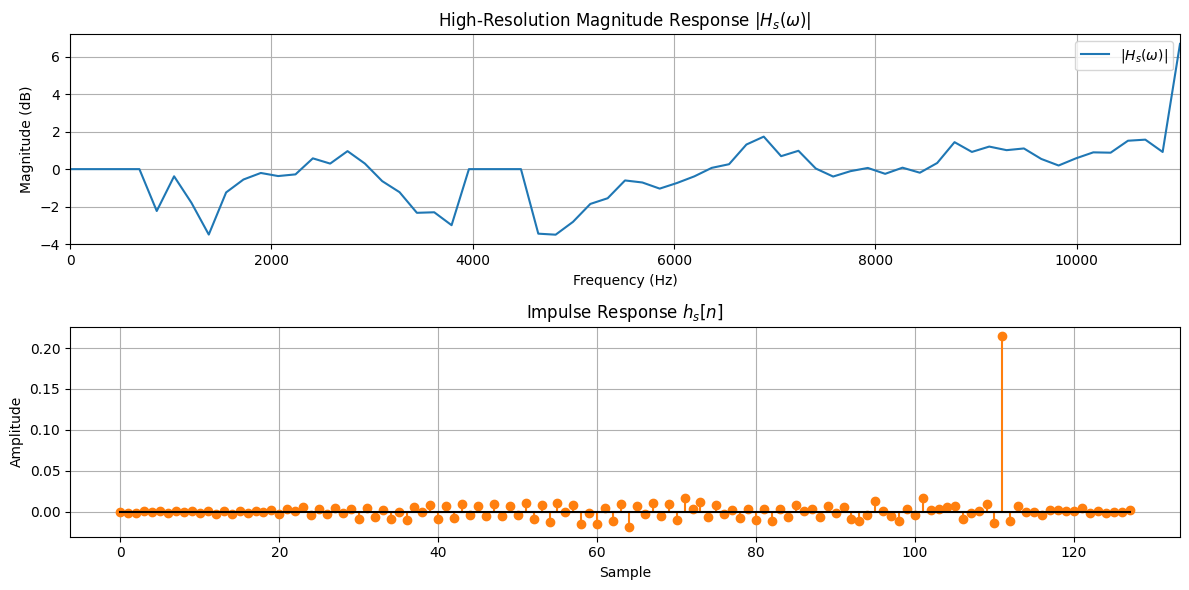

In [73]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import welch, windows
from scipy.fft import irfft, rfftfreq

# Load and normalize the noisy speech signal
fs, data = wavfile.read("speech_w_noise.wav")
xn = data / max(abs(data))  
h_len = 128

# Split signal into speech + noise (full signal) and noise-only segments
noise_start = int(0.0 * fs)  # Adjust based on plot from task a
noise_end = int(1.5 * fs)
noise_segment = xn[noise_start:noise_end]

speech_start = int(3.0 * fs)
speech_end = int(4.5 * fs)
speech_segment = xn[speech_start:speech_end]

# Estimate PSD of speech+noise and noise segments using Welch's method
f_filt, P_xx = welch(speech_segment, fs=fs, nperseg=h_len, noverlap=h_len//2)  # PSD of speech + noise
_, P_vv = welch(noise_segment, fs=fs, nperseg=h_len, noverlap=h_len//2)  # PSD of noise-only

# Estimate noise floor based on the median of the total PSD
noise_floor = np.median(P_vv)  # Estimate noise level

# Refine P_vv by applying the noise floor threshold
P_vv = np.where(P_xx > noise_floor * 1.5, P_xx, noise_floor)  # Separate noise PSD

# Calculate the Wiener filter response H_v(omega) = P_ss / (P_ss + P_vv)
P_ss = P_xx - P_vv  # Estimate signal PSD by subtracting noise
H_v = P_ss / (P_ss + P_vv)

# Apply gain cap to limit the maximum value of H_v
H_v_capped = np.minimum(H_v, 1)
H_s = 1 - H_v_capped
D = (h_len - 1) / 2  
frequencies = rfftfreq(h_len, 1/fs)  
H_s_phase_adjusted = H_s * np.exp(-1j * 2 * np.pi * frequencies * D)

h_s = irfft(H_s_phase_adjusted, n=h_len)
h_s_windowed = h_s * windows.hamming(h_len)

# Plotting
plt.figure(figsize=(12, 6))

# High-resolution frequency response plot of |H_s(ω)|
plt.subplot(2, 1, 1)
plt.plot(f_filt, 20 * np.log10(np.abs(H_s)), label=r"$|H_s(\omega)|$")
plt.xlim([0, fs / 2])
plt.title("High-Resolution Magnitude Response $|H_s(\\omega)|$")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.grid(True)
plt.legend()

# Plot the impulse response h_s[n]
plt.subplot(2, 1, 2)
plt.stem(h_s_windowed, linefmt='C1-', markerfmt='C1o', basefmt='k')
plt.title("Impulse Response $h_s[n]$")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()


[Here](figures/task4c_lf.png) is an example of what the speech enhancing filter's magnitude response might look like.

## d) 

Use the filter you calculated in **c)** to filter the signal $x[n]$, and listen to the result. Do not expect crystal clear audio, this noise filtering technique has a lot of potential for improvement. However, there should absolutely be a noticeable reduction in noise level. 

Finally, plot the envelope of the filtered audio signal alongside the original, and comment on the difference between the two.

Original noisy signal:


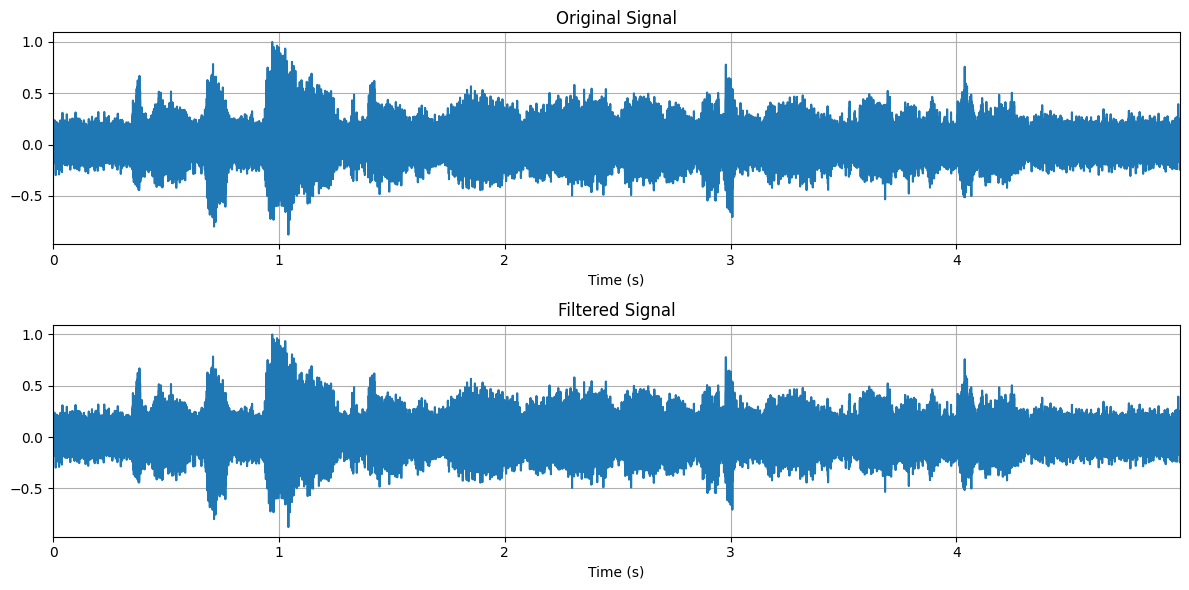

In [74]:
# WRITE YOUR CODE IN THIS CELL:

from scipy.signal import convolve
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt

# Apply the complementary filter to the noisy signal x[n]
filtered_signal = convolve(xn, h_s, mode='same')

# Play the original and filtered audio signals for comparison
print("Original noisy signal:")
#Audio(xn, rate=fs)


# Calculate the envelopes by taking the absolute values and smoothing
envelope_original = np.abs(xn)
envelope_filtered = np.abs(filtered_signal)

# Plot envelopes of the original and filtered signals


plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, len(xn)/fs, len(xn), endpoint=False), xn)
plt.grid(True)
plt.title("Original Signal")
plt.xlabel("Time (s)")
plt.xlim([0, len(xn)/fs])


plt.subplot(2, 1, 2)
plt.plot(np.linspace(0, len(filtered_signal)/fs, len(filtered_signal), endpoint=False), xn)
plt.grid(True)
plt.title("Filtered Signal")
plt.xlabel("Time (s)")
plt.xlim([0, len(xn)/fs])

plt.tight_layout()
plt.show()



Audio(filtered_signal, rate=fs)

# Observations:
# The filtered signal should show a reduction in the envelope’s amplitude,
# particularly in segments dominated by noise. You may notice that the
# envelope of the filtered signal is smoother and has lower peaks in noisy regions,
# indicating noise reduction.


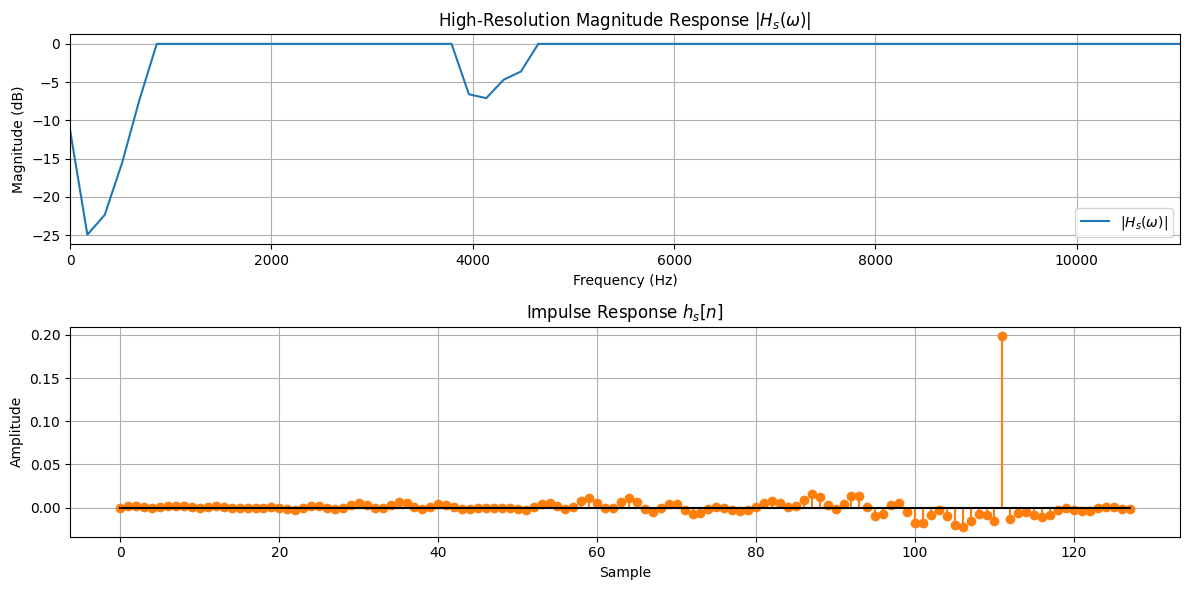

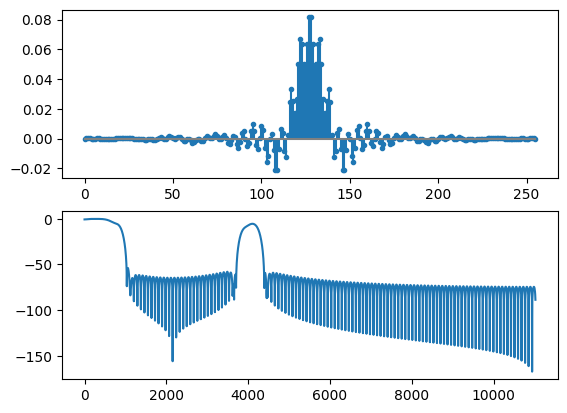

In [64]:
import scipy.signal as sig

fs, data = wavfile.read("speech_w_noise.wav")
x_n = data / max(abs(data))  # Normalize signal to range [-1, 1]

#fs = 8000
t_n = np.linspace(0, 1, fs, endpoint=False)
s_n = np.sin(2*np.pi*440*t_n)
#x_n = s_n + np.random.normal(loc=0, scale=1, size=fs)

h_len = 256 # number of filter taps
f_filt, P_xx = sig.welch(x_n, fs=fs, nperseg=h_len, noverlap=h_len//2)  # Calculate PSD of x[n]

noise_floor = np.median(P_xx)  # Estimate noise level

P_vv = np.where(P_xx < noise_floor*1.5, P_xx, noise_floor)  # Separate noise PSD by setting a threshold for what constitutes a "signal"

P_ss = P_xx - P_vv  # Estimate PSD of s[n] by subtracting noise
H_filt = P_ss/(P_ss + P_vv)  # Calculate Wiener Filter Response H(f)
H_filt = H_filt * np.exp(-2j*np.pi*f_filt/fs*(h_len-1)/2)   # Add delay for causal filter
h_filt = np.fft.irfft(H_filt, n=h_len)  # Calculate desired filter frequency response
h_filt*= sig.windows.hamming(h_len)   # Apply window function
f_2, H_2 = sig.freqz(h_filt, 1, worN=8*h_len, fs=fs)  # Calculate acutal filter frequency response
plt.close(2); plt.figure(2)
plt.subplot(2,1,1)
plt.stem(h_filt, markerfmt='.', basefmt='grey')
plt.subplot(2,1,2)
plt.plot(f_2, 20*np.log10(np.abs(H_2)))

y_n = np.convolve(x_n, h_filt, mode="same")
Audio(y_n, rate=fs)